<a href="https://colab.research.google.com/github/nuvvulapraveen17/MachineLearning-DeepLearning/blob/main/FFNN_Class/FFNN_Generic_MultiClassClasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
# Color map required for better visualization
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# Generating Data

In [3]:
"""
To generate a data, we make use of make_blobs method from sklearn 
it is used for generateing data for lot of ML models for undestanding model working
it take the following parameters inputs as
    (i) number of samples
    (ii) no.of input features(parameters, n_features)
    (iii) centres indicate how many clusters of data we need
    (iv) random_state to replicate the same results every time(repetable)
it gives us data -> data is only input variables
labels -> output(y) for the data
"""

data, labels_orig = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels_orig.shape)

(1000, 2) (1000,)


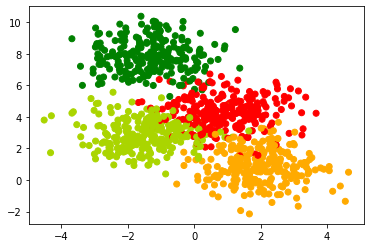

'\nwe can observe from the graph what does it mean by centre=4(clusters) in make_blobs\neven though we have 2 features in input we have 4 diff labels to data.\nIts a multi class classification problem\n'

In [5]:
"""
if we plot the data 
from above the shape of data indicates we have 1000 examples with 2 features
the labels is same 1000 rows and 1 column(y)
if we plot the data we can plot features on x-axis
data[:, 0] -> selecting all the rows but only first feature
data[:, 1] -> selectiong all the rows of data but only second feature
so data[:, 0] -> gives x-co ordinates array for data points
data[:, 1] -> gives y-co ordinates for data points
c is color so for each data points(each cluster) will get one among our cmap colors
"""
plt.scatter(data[:,0], data[:,1], c=labels_orig, cmap=my_cmap)
plt.show()

"""
we can observe from the graph what does it mean by centre=4(clusters) in make_blobs
even though we have 2 features in input we have 4 diff labels to data.
Its a multi class classification problem
"""

# Feed Forward Network - Generic Class

In [6]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

# Train Test Spliting & one-hot encoding

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [8]:
enc = OneHotEncoder()

"""
it converts 0 to a tuple (1, 0, 0, 0) for 4 class classification
 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
 we are transforming both y_train and y_val using one hot encoding
"""

y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)
# we can see 4 features multi class

(750, 4) (250, 4)


# Training Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


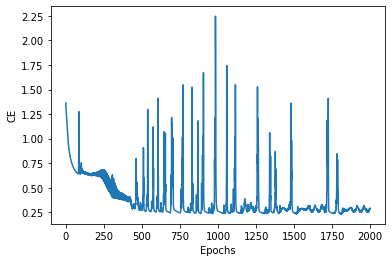

In [9]:
ffsn_multi = FFSN_MultiClass(2,4,[2,3])
ffsn_multi.fit(X_train,y_OH_train,epochs=2000,learning_rate=.005,display_loss=True)

**Observation:** The model is performing well as we can observe the loss is decreasing as it progresses, but still lots of fluctuations.

# Evaluation

In [10]:
"""
  as we are dealing with multi-class classification
  after getting predicted probability distribution
  the output is taken by considering the argamax of that vector
  i.e. the o/p of the network is the class with highest probability
  it will be simply 0, 1, 2 or 3
  but not in one-hot encode vector form(0,0,1,0) type
"""

Y_pred_train = ffsn_multi.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.88
Validation accuracy 0.89


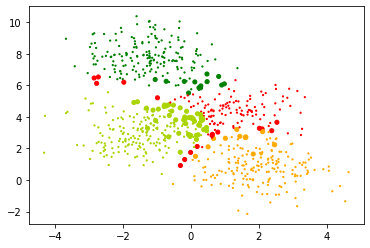

In [11]:
"""
To understand this plot better try to read description about the plot
given in my previous github repo in Sigmoid Class.
"""
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.show()

**Observation:**  It looks the network is learning for 4 class classifications with accuracy of ~ 0.88.

The 0.87 is because we are using 2-layer FFNN which is not able to learn complex non-linearity in the model.

As we can observe there is an overlap of data points near the interface regions of calsses, where we need more non-linear boundary.

The larger size data points in above plot are where the network is not performing well, its nothing but at the interface regions of calsses. which is due to the data generated has overlap at the interface.

# Increasing Hidden layers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


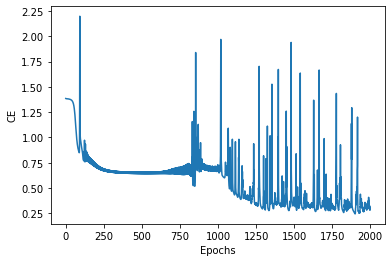

In [14]:
# increasing the no.of hidden units
ffsn_multi = FFSN_MultiClass(2,4,[2,3,4,3])
ffsn_multi.fit(X_train,y_OH_train,epochs=2000,learning_rate=.005,display_loss=True)

**Observation:** It's taking longer time to train a model with just 4 hidden layers, this due to which people use vectorized version with GPU's.

**NOTE:** The above Class is not a Vectorized implementation.

In [15]:
Y_pred_train = ffsn_multi.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.89
Validation accuracy 0.89


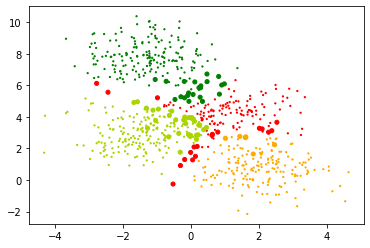

In [16]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.show()